P3

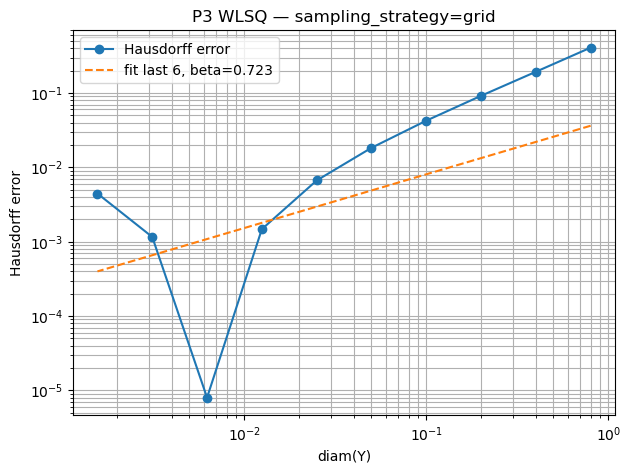

Estimated beta = 0.7230836604432428
Repo sizes: {'P3_s1': 10, 'P3_s2': 10}
true mins: [-59.23266043 -59.23313726 -59.23337567 -59.23349488 -59.23355448
 -59.23358429 -59.23359919 -59.23360664 -59.23361036 -59.23361223]


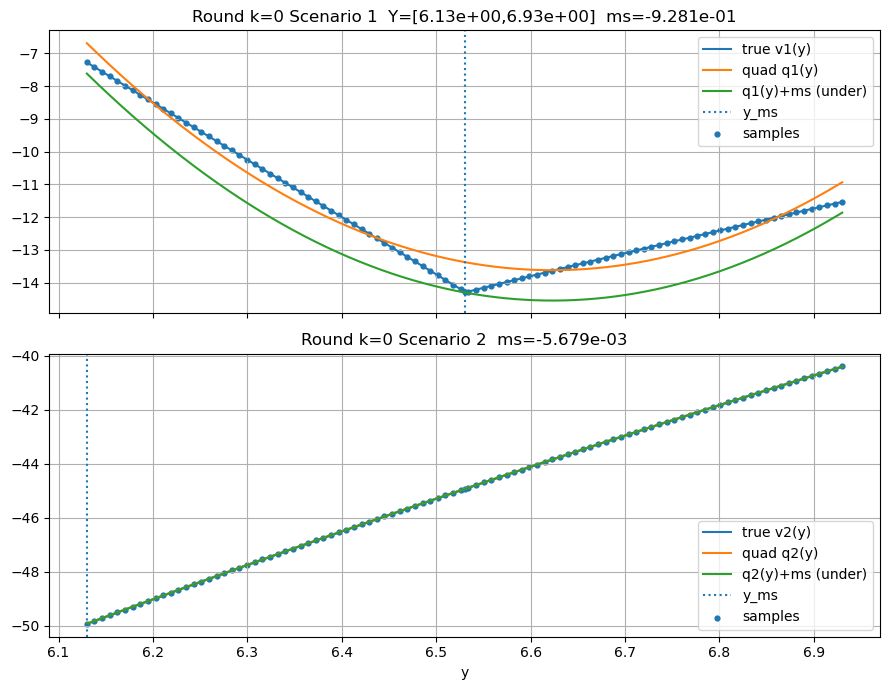

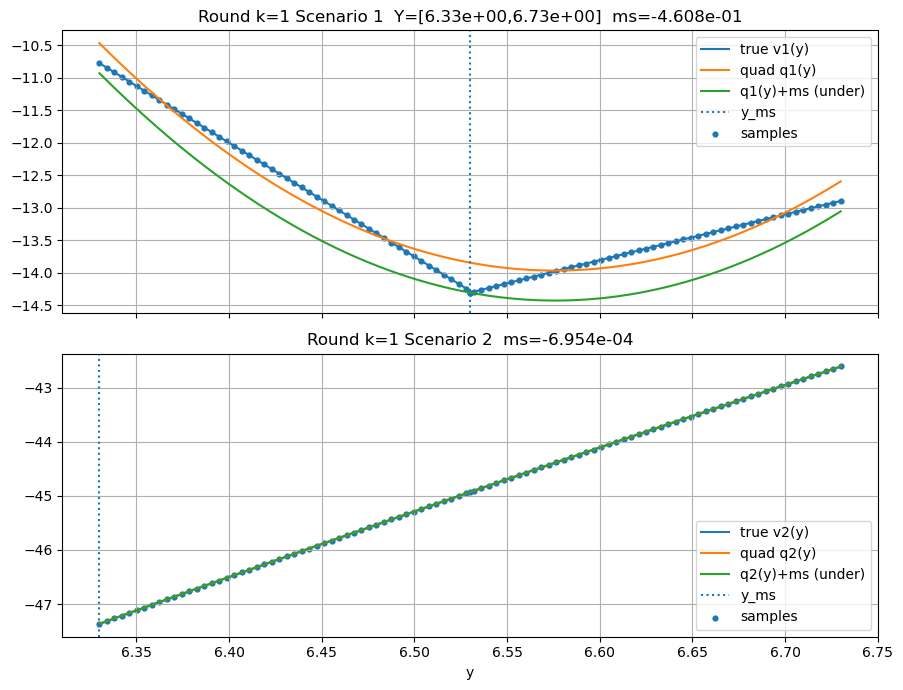

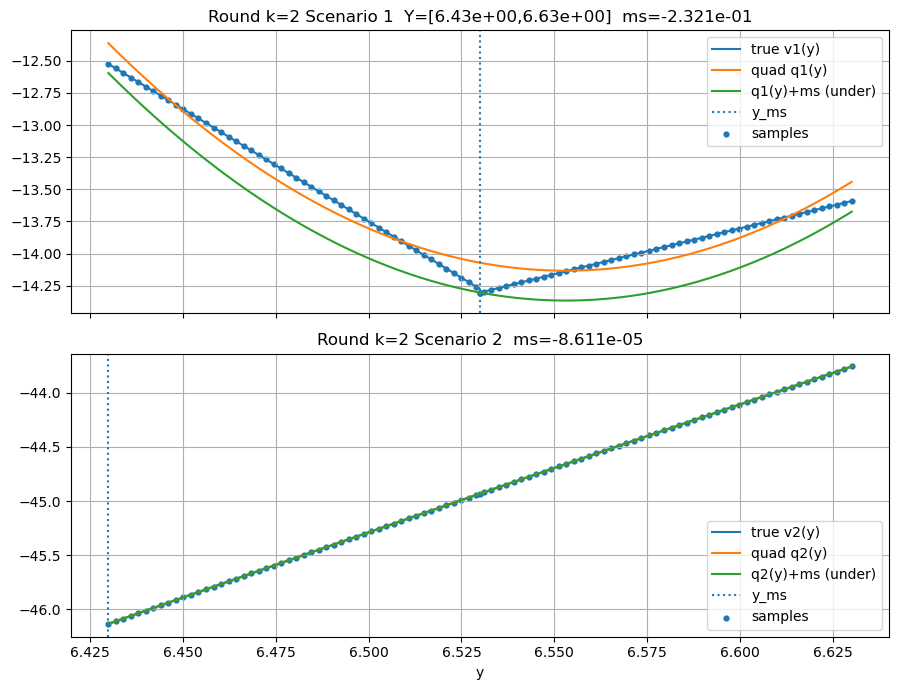

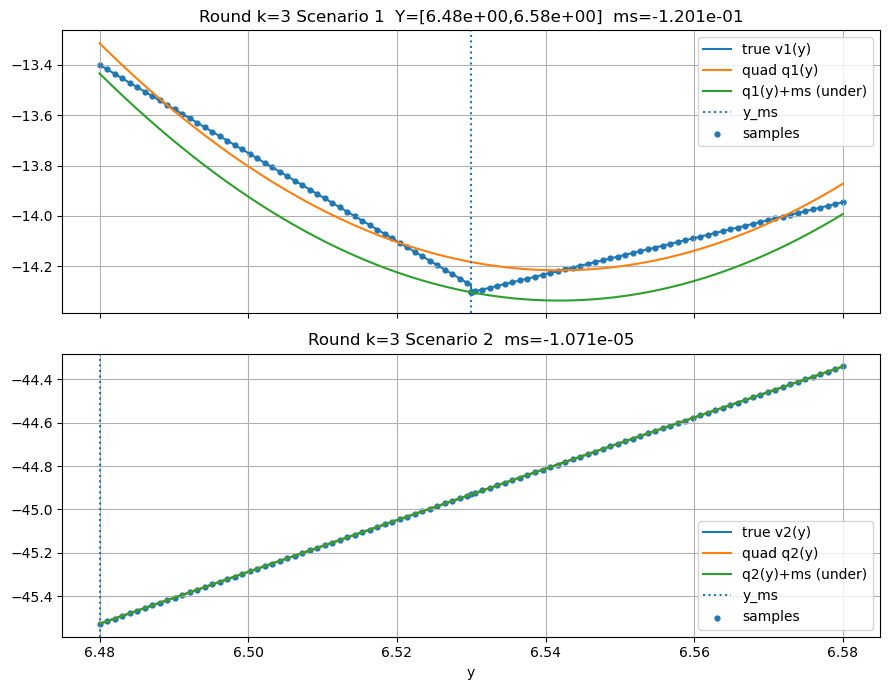

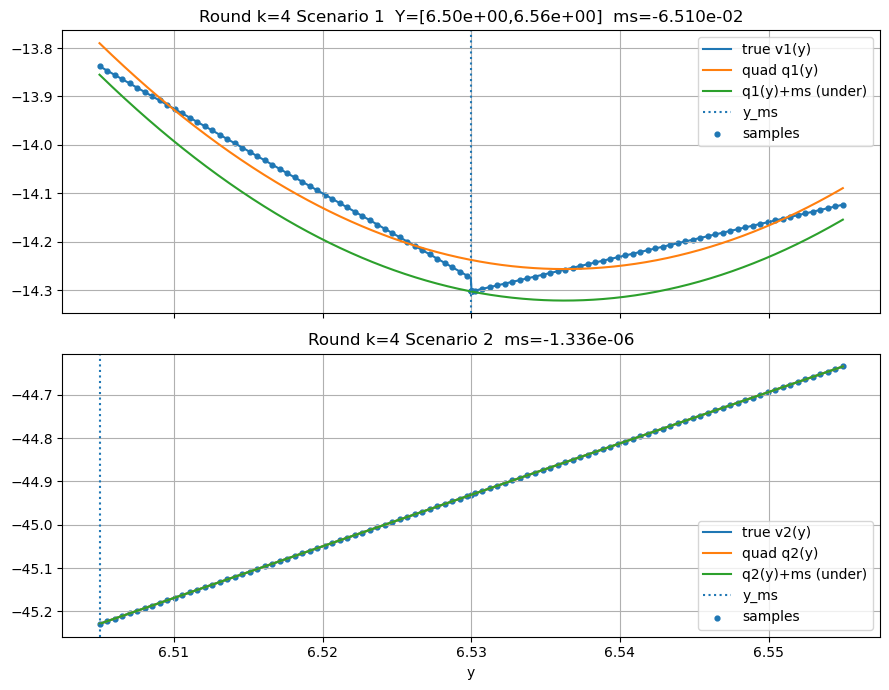

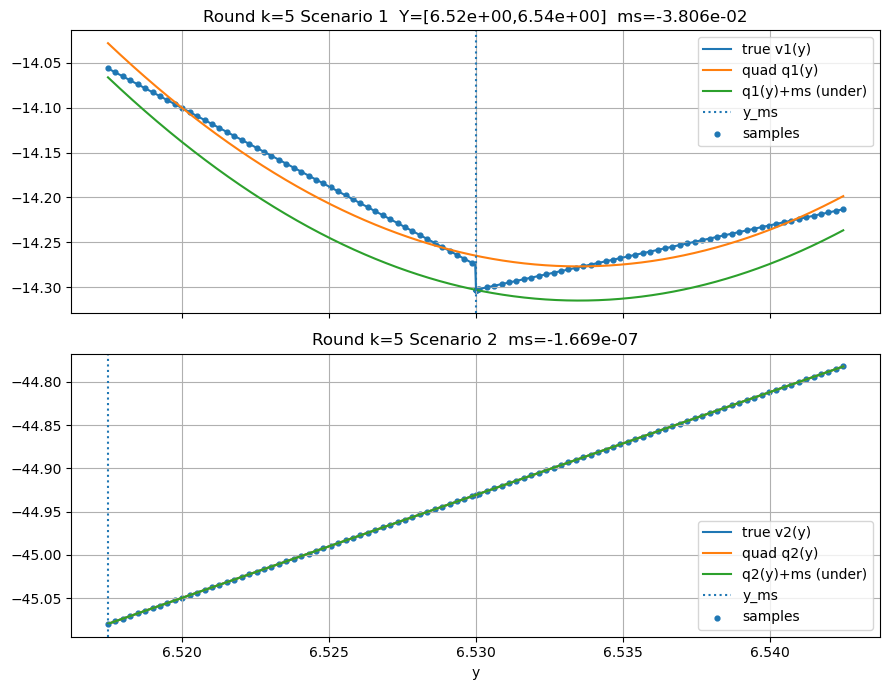

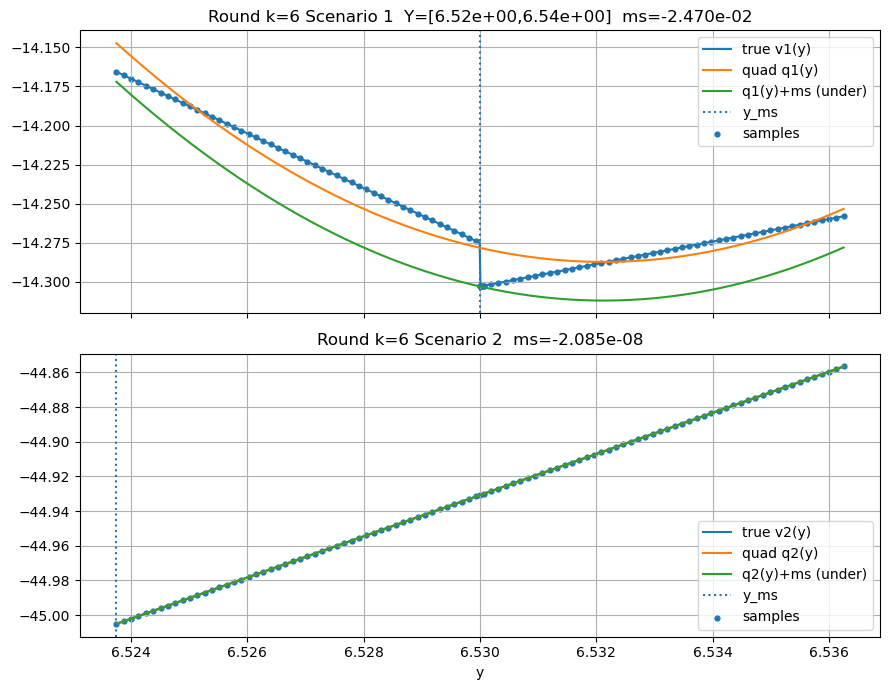

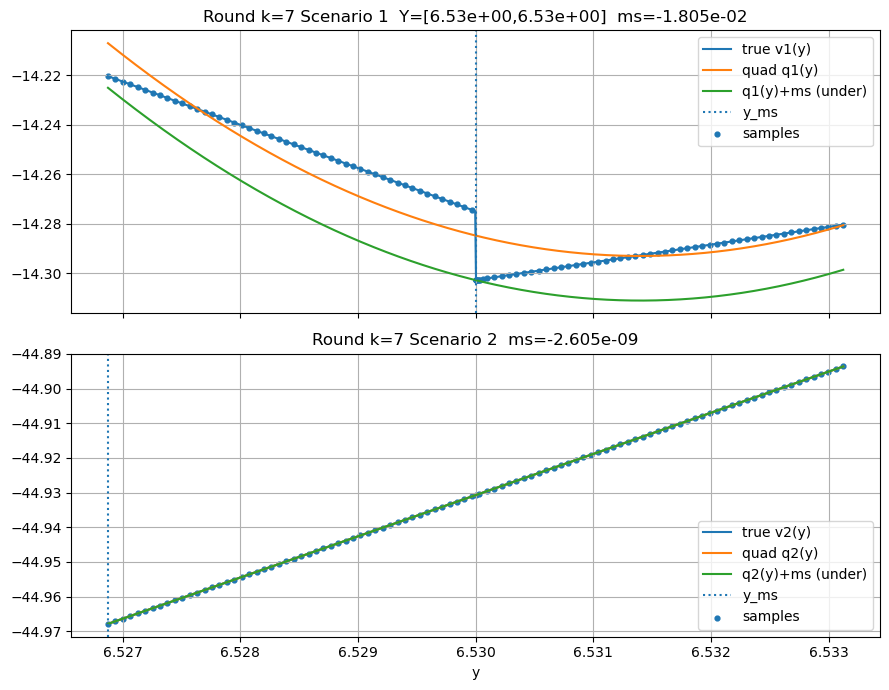

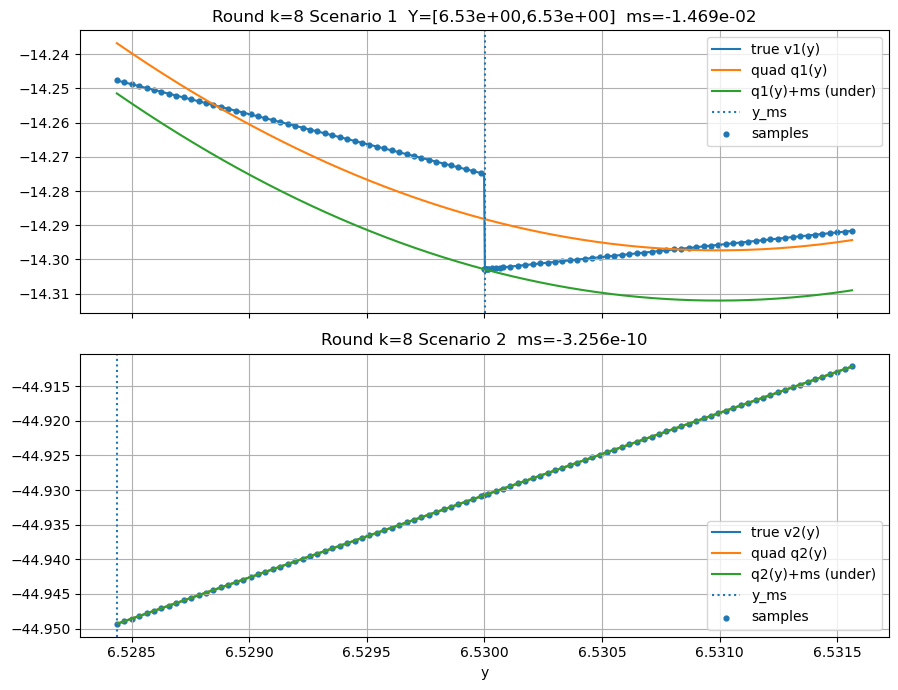

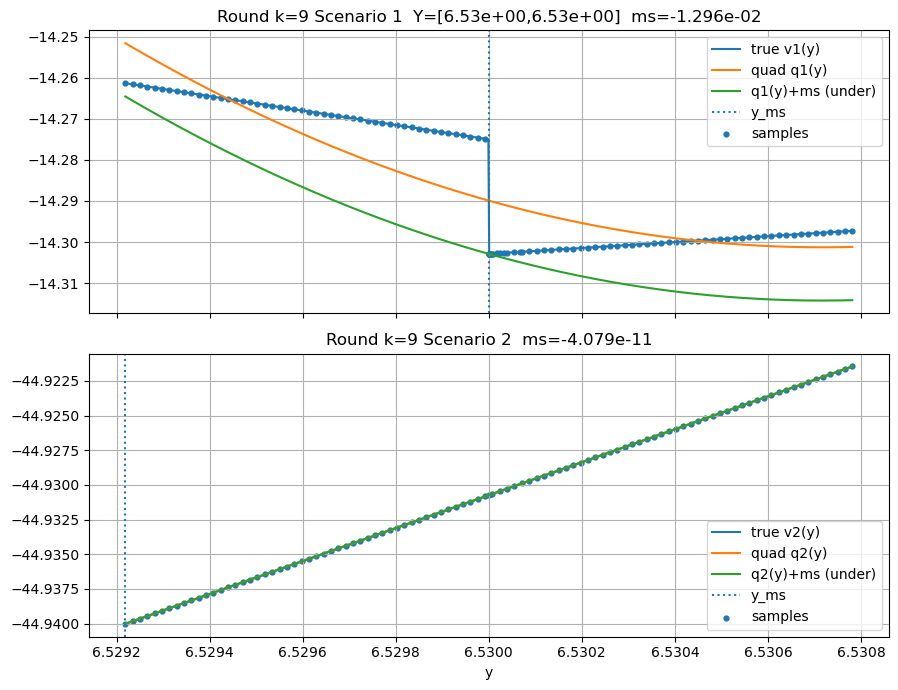

In [1]:
# ============================================================
# P3 (Lipschitz but nonsmooth; not relatively complete recourse globally)
# + WLSQ + Hausdorff error order
# New version matches your "working" ms-shift logic:
#   bounded maximize on each side + safety grid correction
# + Sampling strategies switch:
#   1) random
#   2) grid
#   3) grid_low_weight
#   4) grid_then_ms_nearby (100 + 30 points)
# + Per-iteration plots: two scenarios (true / q / q+ms) + samples + y_ms
# + Final log-log convergence plot
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, Tuple, Dict, List, Optional
from scipy.optimize import minimize_scalar


# -------------------------
# P3 value functions (paper piecewise form)
# Note: outside their effective domains they are +inf.
# -------------------------
def v1(y: float) -> float:
    y = float(y)
    if 5.0 <= y < 6.53:
        return 2.5*y - 10.0*(2.0*y - 10.0)
    if 6.53 <= y <= 20.0:
        return 2.5*y - 10.0*(20.0 / y)
    return float("inf")

def v2(y: float) -> float:
    y = float(y)
    if 2.22 <= y < 3.49:
        return 2.5*y - 20.0*(4.5*y - 10.0)
    if 3.49 <= y <= 20.0:
        return 2.5*y - 20.0*(20.0 / y)
    return float("inf")

def v_total(y: float) -> float:
    return v1(y) + v2(y)

# P3 in the paper is also "sum" style (no 0.5 average here)
P1 = 1.0
P2 = 1.0

# Center point for nested intervals (paper uses y*=6.53)
YSTAR = 6.53


# -------------------------
# MS point repository
# -------------------------
@dataclass
class MSPointRepo:
    points: Dict[str, List[float]] = field(default_factory=dict)
    tol: float = 1e-10

    def add(self, key: str, y: float):
        lst = self.points.setdefault(key, [])
        for yy in lst:
            if abs(yy - y) <= self.tol:
                return
        lst.append(float(y))

    def get_in_interval(self, key: str, Y: Tuple[float, float]) -> np.ndarray:
        lo, hi = Y
        lst = self.points.get(key, [])
        if not lst:
            return np.array([], dtype=float)
        arr = np.array(lst, dtype=float)
        return arr[(arr >= lo) & (arr <= hi)]


# -------------------------
# Quadratic model + diagnostics
# -------------------------
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float
    y_ms: float

    def q(self, y):
        y = np.asarray(y, dtype=float)
        return self.a*y*y + self.b*y + self.c

    def under(self, y):
        return self.q(y) + self.ms


@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray


# -------------------------
# Weighted LS fit: q(y)=a y^2 + b y + c
# -------------------------
def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    y = np.asarray(y, dtype=float).ravel()
    f = np.asarray(f, dtype=float).ravel()
    w = np.asarray(w, dtype=float).ravel()
    assert y.shape == f.shape == w.shape

    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


# -------------------------
# Exact shift to make underestimator on Y
# bounded search (both halves split at YSTAR to reduce nonsmooth risk)
# + safety grid correction but ONLY on finite points (avoid inf)
# -------------------------
def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
    split: float,
    safety_grid: int = 6000,
    safety_tol: float = 1e-12,
) -> Tuple[float, float]:
    lo, hi = Y
    assert lo <= split <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    cand = [lo, split, hi]
    best_val = -np.inf
    best_y = split
    for y in cand:
        val = h(y)
        if np.isfinite(val) and val > best_val:
            best_val = float(val)
            best_y = float(y)

    # local searches on both sides
    for (L, U) in [(lo, split), (split, hi)]:
        if U - L <= 0:
            continue
        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            val = h(res.x)
            if np.isfinite(val) and val > best_val:
                best_val = float(val)
                best_y = float(res.x)

    ms = -best_val
    y_ms = best_y

    # safety correction on dense grid, but only finite v points
    ys = np.linspace(lo, hi, safety_grid)
    vv = np.array([v(float(t)) for t in ys])
    finite = np.isfinite(vv)
    if np.any(finite):
        qv = a*ys[finite]*ys[finite] + b*ys[finite] + c
        viol = np.max((qv + ms) - vv[finite])
        if viol > safety_tol:
            ms -= (viol + safety_tol)

        # refresh y_ms from finite grid
        hs = (a*ys[finite]*ys[finite] + b*ys[finite] + c) - vv[finite]
        y_ms = float(ys[finite][int(np.argmax(hs))])

    return float(ms), float(y_ms)


# ============================================================
# Sampling strategies
# ============================================================
def make_samples(
    sampling_strategy: str,
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    extra_ms_points: int = 30,       # strategy 4
    ms_radius_frac: float = 0.10,    # strategy 4
    split: float = 6.53,
) -> np.ndarray:
    lo, hi = Y

    if sampling_strategy == "random":
        ys = rng.uniform(lo, hi, size=n_samples)

    elif sampling_strategy in ("grid", "grid_low_weight", "grid_then_ms_nearby"):
        ys = np.linspace(lo, hi, n_samples)

    else:
        raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")

    ys = np.unique(ys)

    if sampling_strategy == "grid_then_ms_nearby":
        fs0 = np.array([v(float(t)) for t in ys])
        finite = np.isfinite(fs0)
        ys0 = ys[finite]
        fs0 = fs0[finite]
        if ys0.size >= 3:
            w0 = np.ones_like(fs0)
            a0,b0,c0 = fit_weighted_quadratic(ys0, fs0, w0)
            ms0, y_ms0 = exact_shift_to_underestimator(v, a0,b0,c0, Y, split=split)

            radius = max(ms_radius_frac*(hi-lo), 1e-12)
            L = max(lo, y_ms0 - radius)
            U = min(hi, y_ms0 + radius)
            ys_extra = rng.uniform(L, U, size=extra_ms_points)
            ys = np.unique(np.concatenate([ys, ys_extra]))

    return ys


def make_weights(
    sampling_strategy: str,
    ys: np.ndarray,
    fs: np.ndarray,
    alpha: float = 5.0
) -> np.ndarray:
    if sampling_strategy in ("random", "grid", "grid_then_ms_nearby"):
        return np.ones_like(fs)

    if sampling_strategy == "grid_low_weight":
        fmin = float(np.min(fs[np.isfinite(fs)]))
        w = np.exp(-alpha*(fs - fmin))
        w[~np.isfinite(fs)] = 0.0
        return w

    raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")


# -------------------------
# Build WLSQ underestimator
# -------------------------
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    sampling_strategy: str,
    ms_repo: Optional[MSPointRepo] = None,
    scenario_key: Optional[str] = None,
    use_msrepo: bool = True,
    extra_ms_points: int = 30,
    split: float = 6.53,
) -> Tuple[QuadModel, FitDiag]:
    lo, hi = Y

    ys = make_samples(
        sampling_strategy=sampling_strategy,
        v=v, Y=Y, n_samples=n_samples, rng=rng,
        extra_ms_points=extra_ms_points,
        split=split
    )

    # ensure endpoints and split are included
    ys = np.unique(np.concatenate([ys, np.array([lo, split, hi])]))

    # add ms-repo points
    if use_msrepo and (ms_repo is not None) and (scenario_key is not None):
        extra = ms_repo.get_in_interval(scenario_key, Y)
        if extra.size > 0:
            ys = np.unique(np.concatenate([ys, extra]))

    fs = np.array([v(float(t)) for t in ys])

    # keep only finite points for LS
    finite = np.isfinite(fs)
    ys_fit = ys[finite]
    fs_fit = fs[finite]

    if ys_fit.size < 3:
        # fallback: use a trivial affine-ish underestimator q=const at min finite value
        # (still plots and doesn't crash)
        c0 = float(np.min(fs_fit)) if ys_fit.size > 0 else 0.0
        model = QuadModel(a=0.0, b=0.0, c=c0, ms=0.0, y_ms=split)
        diag = FitDiag(ys=ys_fit, fs=fs_fit, w=np.ones_like(fs_fit))
        return model, diag

    w = make_weights(sampling_strategy, ys_fit, fs_fit)
    a, b, c = fit_weighted_quadratic(ys_fit, fs_fit, w)
    ms, y_ms = exact_shift_to_underestimator(v, a, b, c, Y, split=split)

    if (ms_repo is not None) and (scenario_key is not None):
        ms_repo.add(scenario_key, y_ms)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag = FitDiag(ys=ys_fit, fs=fs_fit, w=w)
    return model, diag


# -------------------------
# Min of quadratic on [lo,hi]
# -------------------------
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))


# -------------------------
# Hausdorff error on Y:
# err(Y) = min_Y v_total(y) - min_Y vhat_total(y)
# For P3, v_total is not constant; we approximate true_min on a dense finite grid.
# -------------------------
def true_min_on_interval(Y: Tuple[float,float], n_grid: int = 8000) -> float:
    lo, hi = Y
    ys = np.linspace(lo, hi, n_grid)
    ft = np.array([v_total(float(t)) for t in ys])
    ft = ft[np.isfinite(ft)]
    if ft.size == 0:
        return float("inf")
    return float(np.min(ft))

def hausdorff_error_for_interval(Y: Tuple[float, float], m1: QuadModel, m2: QuadModel) -> Tuple[float, float, float]:
    lo, hi = Y
    a = P1*m1.a + P2*m2.a
    b = P1*m1.b + P2*m2.b
    c = P1*(m1.c + m1.ms) + P2*(m2.c + m2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    true_min = true_min_on_interval(Y)
    err = true_min - lb
    return lb, err, true_min


# -------------------------
# Run experiment + store per-iteration info
# -------------------------
def run_p3_experiment(
    sampling_strategy: str = "grid",
    eps0: float = 0.4,        # IMPORTANT: keep interval inside finite region around 6.53
    rho: float = 0.5,
    n_levels: int = 10,
    n_samples: int = 100,
    seed: int = 1,
    use_msrepo: bool = True,
    extra_ms_points: int = 30,
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    ms_repo = MSPointRepo()

    eps_list, diam_list, lb_list, err_list, truemin_list = [], [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (YSTAR - eps, YSTAR + eps)

        m1, d1 = build_wlsq_underestimator(
            v1, Y, n_samples=n_samples, rng=rng,
            sampling_strategy=sampling_strategy,
            ms_repo=ms_repo, scenario_key="P3_s1",
            use_msrepo=use_msrepo,
            extra_ms_points=extra_ms_points,
            split=YSTAR
        )
        m2, d2 = build_wlsq_underestimator(
            v2, Y, n_samples=n_samples, rng=rng,
            sampling_strategy=sampling_strategy,
            ms_repo=ms_repo, scenario_key="P3_s2",
            use_msrepo=use_msrepo,
            extra_ms_points=extra_ms_points,
            split=YSTAR
        )

        lb, err, truemin = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)
        truemin_list.append(truemin)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2, lb=lb, err=err, truemin=truemin))

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "truemin": np.array(truemin_list),
        "ms_repo": ms_repo,
        "rounds": rounds,
        "sampling_strategy": sampling_strategy,
        "seed": seed,
        "n_samples": n_samples,
        "use_msrepo": use_msrepo,
    }


def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    if x.size < 2:
        raise RuntimeError("Not enough positive error points to fit slope (need at least 2).")
    beta, _ = np.polyfit(np.log(x), np.log(y), deg=1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 6) -> float:
    diam = out["diam"]
    err = out["err"]

    mask = (diam > 0) & (err > 0) & np.isfinite(err)
    d2 = diam[mask]
    e2 = err[mask]

    if d2.size < 2:
        print("Not enough positive finite error points to fit slope.")
        print("Try smaller eps0 or fewer levels, or check that v_total is finite on intervals.")
        plt.figure()
        plt.plot(diam, err, marker="o")
        plt.title("P3 error (linear scale)")
        plt.xlabel("diam(Y)")
        plt.ylabel("Hausdorff error")
        plt.grid(True)
        plt.show()
        return float("nan")

    K = min(slope_fit_last, d2.size)
    beta = estimate_slope_loglog(d2[-K:], e2[-K:])

    lx = np.log(d2[-K:])
    ly = np.log(e2[-K:])
    c = float(np.mean(ly - beta * lx))
    fit_err = np.exp(beta * np.log(d2) + c)

    plt.figure(figsize=(7,5))
    plt.loglog(d2, e2, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(d2, fit_err, linestyle="--", label=f"fit last {K}, beta={beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    plt.title(f"P3 WLSQ — sampling_strategy={out['sampling_strategy']}")
    plt.legend()
    plt.show()
    return beta


def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 800, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    m1: QuadModel = round_info["m1"]
    m2: QuadModel = round_info["m2"]
    d1: FitDiag = round_info["d1"]
    d2: FitDiag = round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

    ax = axes[0]
    ax.plot(ys, np.array([v1(float(t)) for t in ys]), label="true v1(y)")
    ax.plot(ys, m1.q(ys), label="quad q1(y)")
    ax.plot(ys, m1.under(ys), label="q1(y)+ms (under)")
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 1  Y=[{lo:.2e},{hi:.2e}]  ms={m1.ms:.3e}")
    ax.legend()

    ax = axes[1]
    ax.plot(ys, np.array([v2(float(t)) for t in ys]), label="true v2(y)")
    ax.plot(ys, m2.q(ys), label="quad q2(y)")
    ax.plot(ys, m2.under(ys), label="q2(y)+ms (under)")
    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 2  ms={m2.ms:.3e}")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()


# ============================================================
# RUN (switch sampling_strategy here)
# ============================================================
sampling_strategy = "grid"
# sampling_strategy = "random"
# sampling_strategy = "grid_low_weight"
# sampling_strategy = "grid_then_ms_nearby"

params = dict(
    sampling_strategy=sampling_strategy,
    eps0=0.4,           # IMPORTANT for P3 stability
    rho=0.5,
    n_levels=10,
    n_samples=100,
    seed=1,
    use_msrepo=True,
)

out = run_p3_experiment(**params)

beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("Repo sizes:", {k: len(v) for k, v in out["ms_repo"].points.items()})
print("true mins:", out["truemin"])

for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=900, show_samples=True)


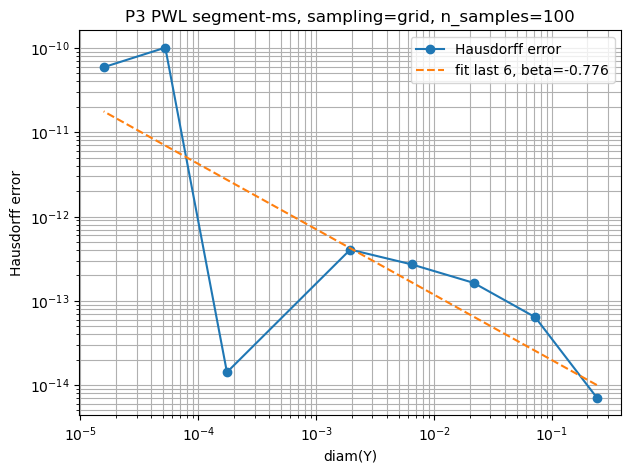

Estimated beta = -0.7760962275898097
true mins: [-59.23361409 -59.23361409 -59.23361409 -59.23361409 -59.23361409
 -59.23361409 -59.23361409 -59.23361409 -59.23361409 -59.23361409]


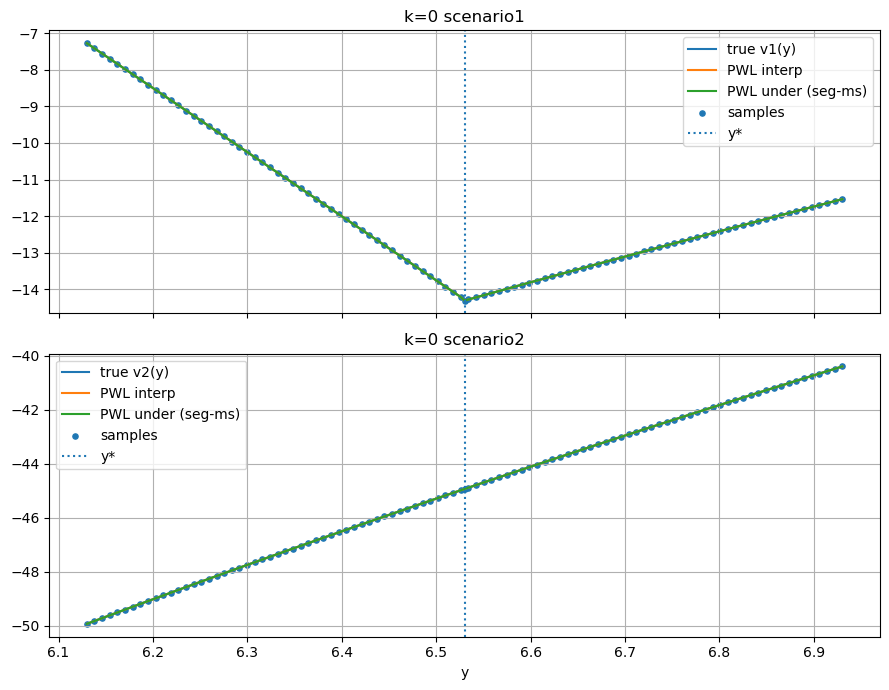

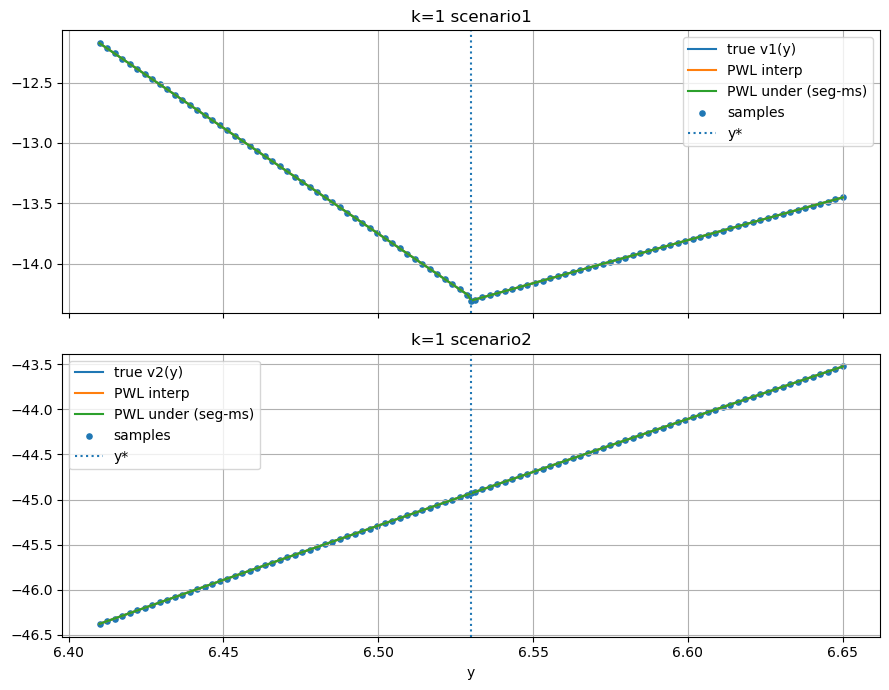

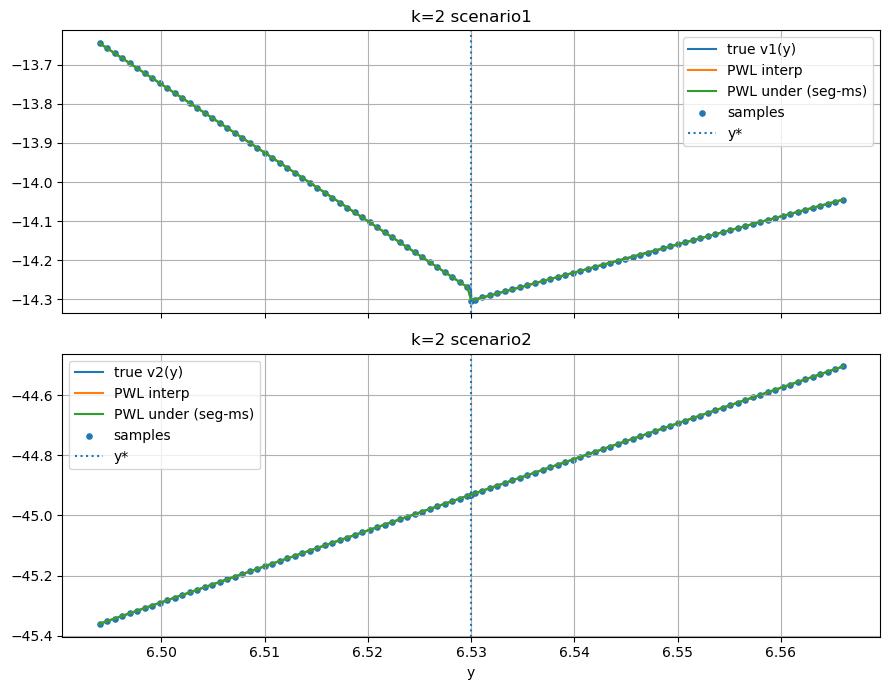

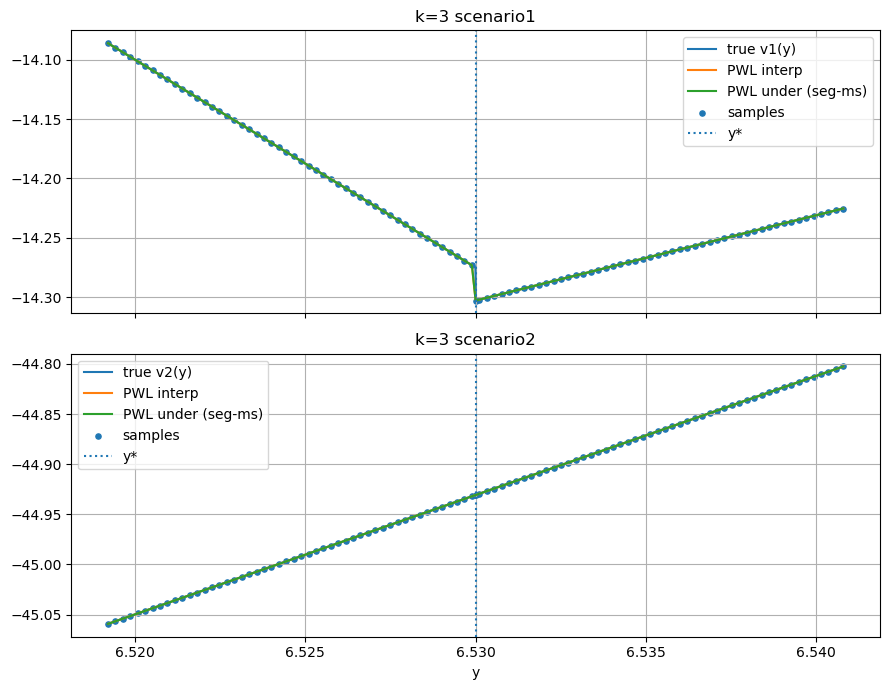

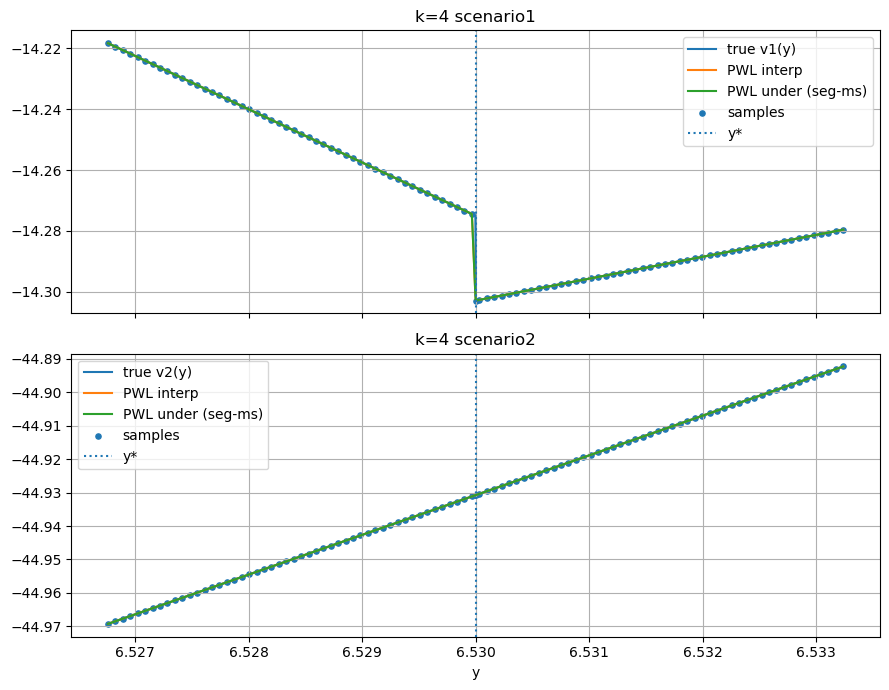

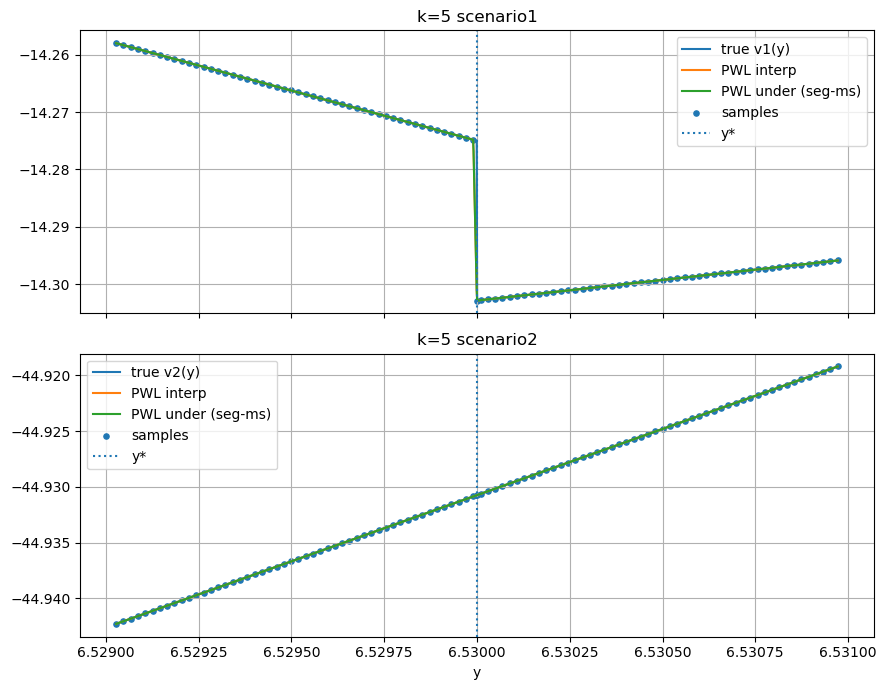

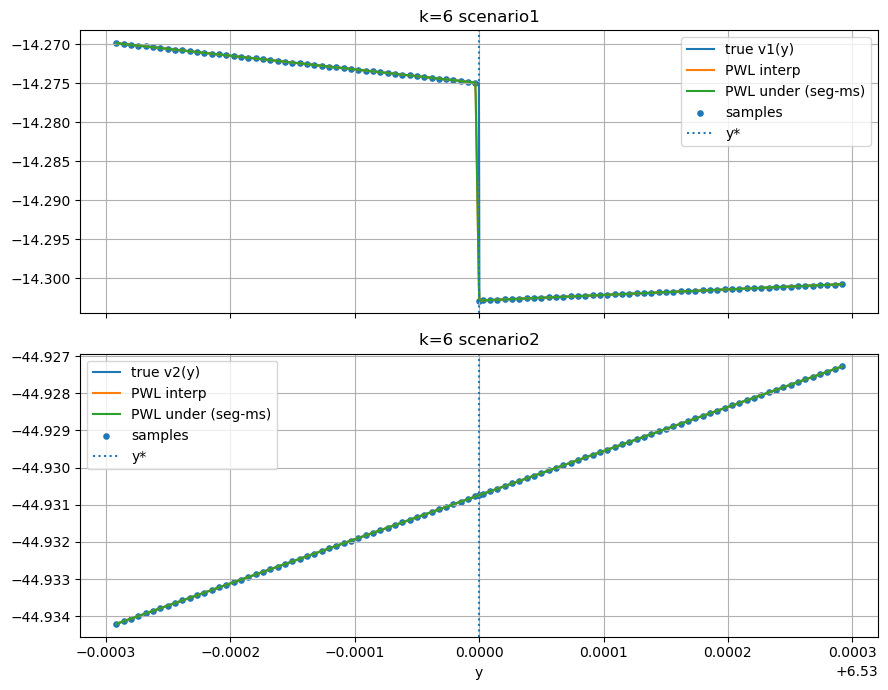

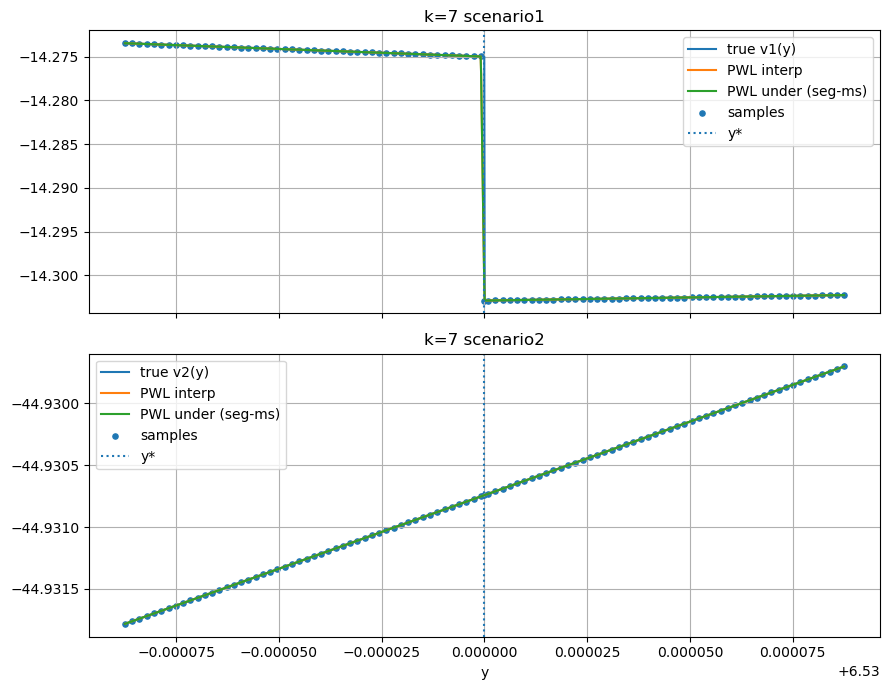

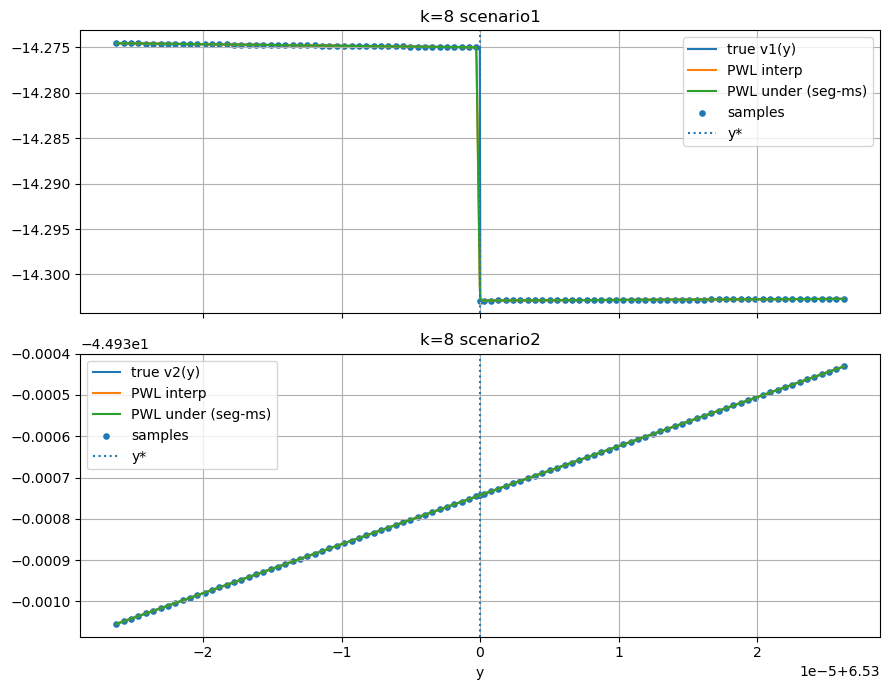

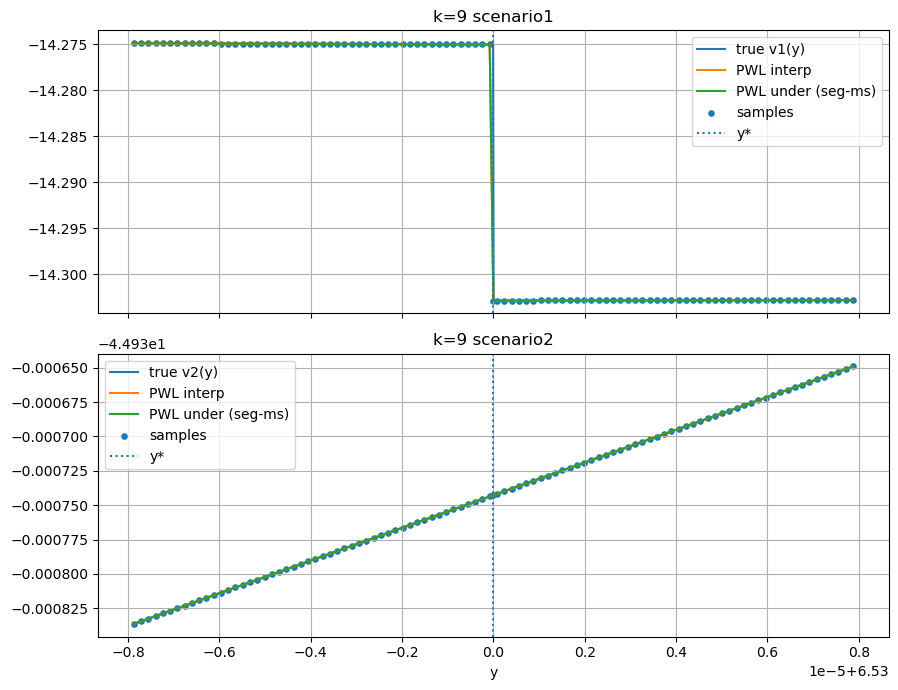

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Dict

# ============================================================
# P3 scenarios (paper piecewise)
# ============================================================
def v1(y: float) -> float:
    y = float(y)
    if 5.0 <= y < 6.53:
        return 2.5*y - 10.0*(2.0*y - 10.0)          # = 100 - 17.5 y
    if 6.53 <= y <= 20.0:
        return 2.5*y - 10.0*(20.0 / y)              # = 2.5 y - 200/y
    return float("inf")

def v2(y: float) -> float:
    y = float(y)
    if 2.22 <= y < 3.49:
        return 2.5*y - 20.0*(4.5*y - 10.0)
    if 3.49 <= y <= 20.0:
        return 2.5*y - 20.0*(20.0 / y)              # = 2.5 y - 400/y
    return float("inf")

def v_total(y: float) -> float:
    return v1(y) + v2(y)

# IMPORTANT: total = sum (weights 1,1), consistent with your P2/P3 working style
P1 = 1.0
P2 = 1.0

# center of nested intervals
YSTAR = 6.53

# ============================================================
# Sampling
# ============================================================
def sample_points(Y: Tuple[float,float], n_samples: int, rng: np.random.Generator, mode: str, ystar: float) -> np.ndarray:
    lo, hi = Y
    if mode == "grid":
        ys = np.linspace(lo, hi, n_samples)
    elif mode == "random":
        ys = rng.uniform(lo, hi, size=n_samples)
    else:
        raise ValueError("mode must be 'grid' or 'random'")

    # ensure endpoints & ystar included (helps capture the regime switch)
    ys = np.unique(np.concatenate([ys, np.array([lo, ystar, hi])]))
    ys.sort()
    return ys

# ============================================================
# Piecewise linear interpolant + per-segment ms shifts
# ============================================================
@dataclass
class PWLSegment:
    xL: float
    xU: float
    slope: float
    intercept: float
    ms: float
    def line(self, x):
        x = np.asarray(x, dtype=float)
        return self.slope*x + self.intercept
    def under(self, x):
        return self.line(x) + self.ms

@dataclass
class PWLModel:
    xs: np.ndarray
    fs: np.ndarray
    segs: list  # list[PWLSegment]

    def interp(self, x):
        x = np.asarray(x, dtype=float)
        y = np.empty_like(x)
        for i, xi in enumerate(x):
            y[i] = self._interp_scalar(float(xi))
        return y

    def under(self, x):
        x = np.asarray(x, dtype=float)
        y = np.empty_like(x)
        for i, xi in enumerate(x):
            y[i] = self._under_scalar(float(xi))
        return y

    def _find_seg_index(self, xi: float) -> int:
        i = int(np.searchsorted(self.xs, xi) - 1)
        if i < 0: i = 0
        if i >= len(self.xs)-1: i = len(self.xs)-2
        return i

    def _interp_scalar(self, xi: float) -> float:
        seg = self.segs[self._find_seg_index(xi)]
        return float(seg.line(xi))

    def _under_scalar(self, xi: float) -> float:
        seg = self.segs[self._find_seg_index(xi)]
        return float(seg.under(xi))

def segment_ms_by_grid(v: Callable[[float], float],
                       xL: float, xU: float,
                       slope: float, intercept: float,
                       n_grid: int = 2001) -> Tuple[float,float]:
    """
    ms = min_{x in [xL,xU]} (v(x) - (slope*x + intercept))
    Return (ms, argmin_x).
    Assumes v is finite on [xL,xU] (we enforce this via eps0 choice).
    """
    xs = np.linspace(xL, xU, n_grid)
    vx = np.array([v(float(t)) for t in xs])
    lx = slope*xs + intercept
    diff = vx - lx
    j = int(np.argmin(diff))
    return float(diff[j]), float(xs[j])

def build_pwl_underestimator(v: Callable[[float], float],
                             xs: np.ndarray,
                             ms_grid: int = 2001) -> Tuple[PWLModel, Dict]:
    xs = np.asarray(xs, dtype=float).ravel()
    xs = np.unique(xs)
    xs.sort()
    fs = np.array([v(float(t)) for t in xs], dtype=float)

    # sanity: ensure finite (P3 requires eps0 small enough)
    if not np.all(np.isfinite(fs)):
        bad = xs[~np.isfinite(fs)]
        raise RuntimeError(f"Non-finite v on some sample points. Try smaller eps0. Bad points: {bad[:10]}")

    segs = []
    ms_list = []
    xms_list = []

    for i in range(len(xs)-1):
        xL, xU = float(xs[i]), float(xs[i+1])
        fL, fU = float(fs[i]), float(fs[i+1])
        if abs(xU - xL) < 1e-15:
            continue
        slope = (fU - fL) / (xU - xL)
        intercept = fL - slope*xL

        ms, x_arg = segment_ms_by_grid(v, xL, xU, slope, intercept, n_grid=ms_grid)
        segs.append(PWLSegment(xL=xL, xU=xU, slope=slope, intercept=intercept, ms=ms))
        ms_list.append(ms)
        xms_list.append(x_arg)

    model = PWLModel(xs=xs, fs=fs, segs=segs)
    diag = {"ms_per_segment": np.array(ms_list), "x_ms_per_segment": np.array(xms_list)}
    return model, diag

# ============================================================
# True min and Relax min on interval (dense grid)
# ============================================================
def true_min_on_interval(Y: Tuple[float,float], n_grid: int = 20001) -> float:
    lo, hi = Y
    xs = np.linspace(lo, hi, n_grid)
    ft = np.array([v_total(float(t)) for t in xs])
    ft = ft[np.isfinite(ft)]
    if ft.size == 0:
        return float("inf")
    return float(np.min(ft))

def hausdorff_error_for_interval_grid(Y: Tuple[float,float],
                                      m1: PWLModel,
                                      m2: PWLModel,
                                      n_grid: int = 20001) -> Tuple[float,float,float,float]:
    lo, hi = Y
    xs = np.linspace(lo, hi, n_grid)

    relax = P1*m1.under(xs) + P2*m2.under(xs)
    j = int(np.argmin(relax))
    lb = float(relax[j])
    y_argmin = float(xs[j])

    tmin = true_min_on_interval(Y, n_grid=n_grid)
    err = tmin - lb
    return lb, err, y_argmin, tmin

# ============================================================
# Experiment runner + plots
# ============================================================
def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0) & np.isfinite(y)
    x = x[mask]; y = y[mask]
    if x.size < 2:
        return float("nan")
    beta, _ = np.polyfit(np.log(x), np.log(y), 1)
    return float(beta)

def run_p3_pwl_experiment(
    sampling: str = "grid",
    eps0: float = 0.4,      # IMPORTANT: keep interval within finite domain
    rho: float = 0.5,
    n_levels: int = 10,
    n_samples: int = 100,
    seed: int = 1,
    ms_grid: int = 2001,
    grid_min: int = 20001
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)

    diam_list, err_list, lb_list, tmin_list = [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0*(rho**k)
        Y = (YSTAR - eps, YSTAR + eps)

        xs = sample_points(Y, n_samples=n_samples, rng=rng, mode=sampling, ystar=YSTAR)

        m1, d1 = build_pwl_underestimator(v1, xs, ms_grid=ms_grid)
        m2, d2 = build_pwl_underestimator(v2, xs, ms_grid=ms_grid)

        lb, err, y_argmin, tmin = hausdorff_error_for_interval_grid(Y, m1, m2, n_grid=grid_min)

        diam_list.append(2*eps)
        err_list.append(err)
        lb_list.append(lb)
        tmin_list.append(tmin)

        rounds.append(dict(k=k, Y=Y, xs=xs, m1=m1, m2=m2, d1=d1, d2=d2,
                           lb=lb, err=err, y_argmin=y_argmin, tmin=tmin))

    return dict(
        diam=np.array(diam_list),
        err=np.array(err_list),
        lb=np.array(lb_list),
        tmin=np.array(tmin_list),
        rounds=rounds,
        params=dict(sampling=sampling, eps0=eps0, rho=rho, n_levels=n_levels, n_samples=n_samples, seed=seed)
    )

def plot_convergence(out: Dict[str, object], slope_fit_last: int = 6) -> float:
    diam = out["diam"]
    err  = out["err"]
    mask = (diam > 0) & (err > 0) & np.isfinite(err)
    d2 = diam[mask]; e2 = err[mask]

    if d2.size < 2:
        print("Not enough positive error points to fit slope.")
        plt.figure(figsize=(6,4))
        plt.plot(diam, err, marker="o")
        plt.title("P3 error (linear scale)")
        plt.xlabel("diam(Y)")
        plt.ylabel("Hausdorff error")
        plt.grid(True)
        plt.show()
        return float("nan")

    K = min(slope_fit_last, d2.size)
    beta = estimate_slope_loglog(d2[-K:], e2[-K:])

    lx = np.log(d2[-K:])
    ly = np.log(e2[-K:])
    c = float(np.mean(ly - beta*lx))
    fit = np.exp(beta*np.log(d2) + c)

    plt.figure(figsize=(7,5))
    plt.loglog(d2, e2, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(d2, fit, linestyle="--", label=f"fit last {K}, beta={beta:.3f}")
    p = out["params"]
    plt.title(f"P3 PWL segment-ms, sampling={p['sampling']}, n_samples={p['n_samples']}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()
    return beta

def plot_round(round_info: Dict[str, object], n_grid: int = 1400):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    xs = round_info["xs"]
    m1, m2 = round_info["m1"], round_info["m2"]

    grid = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2,1,sharex=True,figsize=(9,7))

    ax = axes[0]
    ax.plot(grid, [v1(float(t)) for t in grid], label="true v1(y)")
    ax.plot(grid, m1.interp(grid), label="PWL interp")
    ax.plot(grid, m1.under(grid), label="PWL under (seg-ms)")
    ax.scatter(xs, [v1(float(t)) for t in xs], s=14, label="samples")
    ax.axvline(YSTAR, linestyle=":", label="y*")
    ax.grid(True)
    ax.set_title(f"k={k} scenario1")
    ax.legend()

    ax = axes[1]
    ax.plot(grid, [v2(float(t)) for t in grid], label="true v2(y)")
    ax.plot(grid, m2.interp(grid), label="PWL interp")
    ax.plot(grid, m2.under(grid), label="PWL under (seg-ms)")
    ax.scatter(xs, [v2(float(t)) for t in xs], s=14, label="samples")
    ax.axvline(YSTAR, linestyle=":", label="y*")
    ax.grid(True)
    ax.set_title(f"k={k} scenario2")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()

# ============================================================
# RUN (edit here)
# ============================================================
params = dict(
    sampling="grid",   # "grid" or "random"
    eps0=0.4,          # IMPORTANT: keep finite for P3
    rho=0.3,
    n_levels=10,
    n_samples=100,
    seed=1,
    ms_grid=2001,
    grid_min=20001,
)

out = run_p3_pwl_experiment(**params)
beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("true mins:", out["tmin"])

for r in out["rounds"]:
    plot_round(r, n_grid=1600)
